In [ ]:
!pip install kaggle

In [ ]:
!pip install captum

# Invasive Ductal Carcinoma (IDC)

In this tutorial we will implement a **breast cancer image** classifier with the task of distinguishing IDC ([Invasive Ductal Carcinoma](https://www.hopkinsmedicine.org/breast_center/breast_cancers_other_conditions/invasive_ductal_carcinoma.html)) vs non-IDC images. 

Invasive ductal carcinoma (IDC), also known as infiltrating ductal carcinoma, is cancer that began growing in a milk duct and has invaded the fibrous or fatty tissue of the breast outside of the duct. IDC is the most common form of breast cancer, representing 80 percent of all breast cancer diagnoses.

We will use a [small dataset](https://www.kaggle.com/simjeg/lymphoma-subtype-classification-fl-vs-cll) publicly available on Kaggle. 

**Credits** to Kaggle user [Jegs](https://www.kaggle.com/simjeg) for the reduced dataset used in this tutorial and [Andrew Janowczyk](http://www.andrewjanowczyk.com/use-case-6-invasive-ductal-carcinoma-idc-segmentation/) for the original dataset (`~1.6GB`)

In the following, we will train a small ConvNet model, and we will try to interpret it using LIME, Anchors, contrastive and gradient-based methods.

__NOTE: To download the dataset and follow this tutorial, you need to have an account on Kaggle.__

In [1]:
import os
import stat
import json
from ipywidgets import Password
from ipywidgets import widgets
from IPython.display import display
from IPython.display import Image

## Download the dataset

### Create and place your API token

To be able to download datasets using the Kaggle API, please create and download your API token.
1. Go to [Kaggle](https://www.kaggle.com/) and log in.
2. Go to your account (locate your profile image at the top-right corner of the page)

![](kaggle_account.png)

3. Scroll down your account page until you find the API cell, and click on the "Create new API token" button.

![](api_key.png)

This will download a file called `kaggle.json`. This file contains the credentials that the Kaggle API will need, but you need to place it in the correct folder. 

In [ ]:
user = widgets.Text(
    placeholder='Insert your Kaggle username!',
    description='User',
    disabled=False
)

pwd = Password(
    description='Key',
    placeholder='Insert key for user {}'.format(user.value)
)

def callback(wdgt):
    folder = os.path.expanduser('~/.kaggle')
    os.makedirs(folder, exist_ok=True)
    file = '{}/kaggle.json'.format(folder)
    with open(file, 'w') as kaggle_file:
        json.dump({
            'username': user.value,
            'key': wdgt.value
        }, kaggle_file)
        
        print("Credentials created in {}".format(folder))
    os.chmod(file, stat.S_IREAD | stat.S_IWRITE)

user.on_submit(lambda wdg: display(pwd))
pwd.on_submit(callback)

display(user)

### Download the breast cancer dataset

In [11]:
import kaggle

DATASET_FOLDER = './breast_cancer/'
os.makedirs(DATASET_FOLDER, exist_ok=True)

In [12]:
kaggle.api.authenticate()

In [6]:

kaggle.api.dataset_download_files('simjeg/lymphoma-subtype-classification-fl-vs-cll', 
                                  path=DATASET_FOLDER, unzip=True)

In [7]:
os.listdir(DATASET_FOLDER)

['X.npy', 'Y.npy']

## Setup the task

### Load dataset

Let's load the dataset and split it in train (60%), validation (20%) and test (20%). 

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
# If you want replicate the same results, fix the seed
seed = 100
# seed = None
np.random.seed(seed)

X = np.load(os.path.join(DATASET_FOLDER, 'X.npy'))
y = np.load(os.path.join(DATASET_FOLDER, 'Y.npy'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

Sanity check of the splits distributions

In [10]:
label2idx = {
    'non-IDC': 0,
    'IDC': 1
}
idx2label = ['non-IDC', 'IDC']

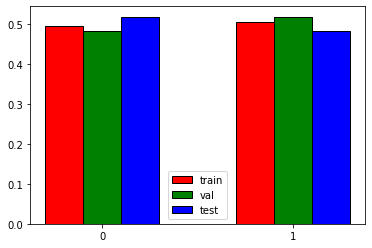

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

bar_width = 0.2

pos_train = np.array([-0.2, 0.8])
pos_val = pos_train + bar_width
pos_test = pos_val + bar_width

plt.bar(pos_train, [np.mean(y_train==label2idx['non-IDC']), np.mean(y_train==label2idx['IDC'])], width=bar_width, color='r', edgecolor='k', label='train')
plt.bar(pos_val, [np.mean(y_val==label2idx['non-IDC']), np.mean(y_val==label2idx['IDC'])], width=bar_width, color='g', edgecolor='k', label='val')
plt.bar(pos_test, [np.mean(y_test==label2idx['non-IDC']), np.mean(y_test==label2idx['IDC'])], width=bar_width, color='b', edgecolor='k', label='test')

plt.xticks([0, 1])
plt.legend()

plt.show()

To have a sense of the data let's have a look at some samples.

In [12]:
def show_samples():
    non_idc_sample_idx = np.random.choice(np.argwhere(y == label2idx['non-IDC']).squeeze())
    non_idc_sample = X[non_idc_sample_idx]
    
    idc_sample_idx = np.random.choice(np.argwhere(y == label2idx['IDC']).squeeze())
    idc_sample = X[idc_sample_idx]
    
    plt.figure()
    
    plt.subplot(121)
    plt.imshow(non_idc_sample)
    plt.title('non-IDC (sample idx: {})'.format(non_idc_sample_idx))
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(idc_sample)
    plt.title('IDC (sample idx: {})'.format(idc_sample_idx))
    plt.axis('off')
    
    plt.show()

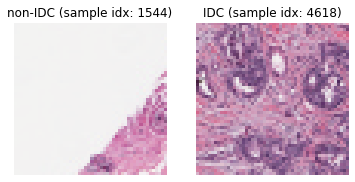

In [13]:
show_samples()

What's the image size? And are the images normalized?

In [14]:
print('Image shape: {}'.format(X.shape[1:]))

print('Min value: {}\nMax value: {}'.format(
    np.max(X),
    np.min(X)
))

Image shape: (50, 50, 3)
Min value: 255
Max value: 2


Let's create a preprocessing pipeline in PyTorch to convert the `np.array`s to `torch.tensor`s and then normalize them to the range `[-1.0, 1.0]` for each channel.

In [15]:
import torch
import torchvision

preprocessor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0]*3, [255]*3, inplace=True)
])

We now create a `torch.utils.data.Dataset` wrapper around our data so we can use the `torch.utils.data.DataLoader` to then perform some training utilities (i.e. batching).

In [16]:
class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, _X, _y):
        # Preprocess the data
        self._X = torch.stack([preprocessor(x) for x in _X])
        self._y = torch.tensor(_y.astype(np.int))
        
    def __len__(self):
        return len(self._X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return {'image': self._X[idx], 'label': self._y[idx]}
    
    @property
    def X(self):
        return self._X

In [17]:
train_set = BreastCancerDataset(X_train, y_train)
valid_set = BreastCancerDataset(X_val, y_val)
test_set  = BreastCancerDataset(X_test, y_test)

### Let's create our CNN

Define the model ...

In [18]:
from torch import nn

class CancerCNN(nn.Module):
    def _conv_op(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 9, padding=4), # this maintains the same size
            nn.Tanh()
        )
    
    def _fc_op(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Tanh()
        )
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = self._conv_op(3, 32)
        self.conv2 = self._conv_op(32, 64)
        self.conv3 = self._conv_op(64, 128)
        
        self.max_pool_2 = nn.MaxPool2d(2)
        self.max_pool_5 = nn.MaxPool2d(5)
        
        self.fc1 = self._fc_op(128, 32)
        self.fc2 = self._fc_op(32, 2)
        
    def forward(self, x, return_argmax=False):
        # size = (?, 50, 50, 3)
        x = self.conv1(x)
        # size = (?, 50, 50, 32)
        x = self.max_pool_2(x)
        # size = (?, 25, 25, 32)
        x = self.conv2(x)
        # size = (?, 25, 25, 64)
        x = self.max_pool_5(x)
        # size = (?, 5, 5, 64)
        x = self.conv3(x)
        # size = (?, 5, 5, 128)
        x = self.max_pool_5(x)
        # size = (?, 1, 1, 128)
        x = x.view(-1, 128)
        # size = (?, 128)
        x = self.fc1(x)
        # size = (?, 32)
        x = self.fc2(x)
        # size = (?, 2)
        if return_argmax:
            argmax = torch.argmax(x, dim=1)
            return argmax
        return x

... and then instantiate it.

In [19]:
# set the seed for reproducibility
torch.manual_seed(1123)

cnn_model = CancerCNN()
print(cnn_model)

CancerCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool_5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Tanh()
  )
)


### Now let's train the model

In [20]:
batch_size = 4
learning_rate = 1e-4
n_epochs = 20

ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

model_file = os.path.join(DATASET_FOLDER, 'cancer_cnn_trained.model')

In [21]:
torch.manual_seed(13901)

# randomized data loader for training
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [22]:
def compute_metrics(model, loader, set_name, set_size):
    total_loss = 0
    correct = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    def precision_and_recall(t, f, f_other):
        if t == 0:
            return 0, 0
        return (np.float(t)/np.float(t+f_other), np.float(t)/np.float(t+f))
    
    for i, data in enumerate(loader):
        images = data['image']
        labels = data['label']
        
        logits = model(images)
        loss = ce_loss(logits, labels)
        
        predicted = torch.argmax(logits, dim=1)
        curr_correct = (labels == predicted).sum().item()
        pos_count = (predicted == 1).sum().item()
        neg_count = len(predicted) - pos_count
        curr_correct = (labels == predicted)
        curr_tp = ((labels == 1) & curr_correct).sum().item()
        curr_tn = ((labels == 0) & curr_correct).sum().item()
        correct += curr_correct.sum().item()
        
        TP += curr_tp 
        TN += curr_tn
        FP += pos_count - curr_tp
        FN += neg_count - curr_tn
        
        total_loss += loss.item()*len(images)
        
    print('{}..'.format(set_name))
    print('\t.. loss: {}'.format(total_loss/set_size))
    print('\t.. accuracy: {}%'.format((correct*100.0)/set_size))
    print('\t.. TP={}, TN={}, FP={}, FN={}'.format(TP, TN, FP, FN))
    precision_0, recall_0 = precision_and_recall(TN, FN, FP)
    precision_1, recall_1 = precision_and_recall(TP, FP, FN)
    print('\t.. precision(0): {}'.format(precision_0))
    print('\t.. recall(0): {}'.format(recall_0))
    print('\t.. precision(1): {}'.format(precision_1))
    print('\t.. recall(1): {}'.format(recall_1))

In [23]:
from IPython.display import clear_output

def print_summary(model, train_loss, print_test=False):
    clear_output()
    print('================= Summary =================')
    print('Training loss: {}'.format(train_loss/len(train_set)))
    compute_metrics(model, val_loader, 'Validation', len(valid_set))
    if print_test:
        compute_metrics(model, test_loader, 'Test', len(test_set))
    print('===========================================')
    print()

In [25]:
import sys

LEN_BAR = 40

for e in range(1, n_epochs+1):
    
    if e > 1:
        clear_output()
        print_summary(cnn_model, total_train_loss, False)
    
    total_train_loss = 0
    n_samples = 0
    
    for i, data in enumerate(train_loader):
        # get current data
        images = data['image']
        labels = data['label']
        
        n_samples += len(images)

        # 
        optimizer.zero_grad()

        logits = cnn_model(images)
        loss = ce_loss(logits, labels)
        total_train_loss += loss.item()*len(images)
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            frac = i/len(train_loader)
            n_progress = int(frac*LEN_BAR)
            message = ('Epoch {} |{}{}{}| {:0.2f}% (Batch Loss: {:0.5f}, Average Loss: {:0.5f})'.format(
                e,
                '='*n_progress,
                '>' if n_progress < LEN_BAR else '',
                '.'*max(0, LEN_BAR - n_progress - 1),
                frac*100,
                loss.item(),
                total_train_loss/n_samples
            ))
            sys.stdout.write('\r' + message)
            sys.stdout.flush()
            torch.save(cnn_model.state_dict(), model_file) # save

    
clear_output()
print_summary(cnn_model, total_train_loss, True)  
torch.save(cnn_model.state_dict(), model_file) # save

================= Summary =================
Training loss: 0.5839828270170329
Validation..
	.. loss: 0.562821816216718
	.. accuracy: 71.8018018018018%
	.. TP=460, TN=337, FP=198, FN=115
	.. precision(0): 0.6299065420560748
	.. recall(0): 0.745575221238938
	.. precision(1): 0.8
	.. recall(1): 0.6990881458966566

Epoch 3 |===>....................................| 9.62% (Batch Loss: 0.79455, Average Loss: 0.59901)

KeyboardInterrupt: 

If you are too impatient to train the model (or you want to reproduce the results in this notebook), you can download and load the pre-trained model by running the following cell.

In [115]:
def import_model_from_box():
    import wget, math, shutil
    pretrained_model_file = os.path.join(DATASET_FOLDER, 'pretrained.model')
    file = wget.download('https://ibm.box.com/shared/static/rgoxyepbdwahd65m9ou3t9cmobq38qxa.model', 
                         pretrained_model_file)
    shutil.move(file,pretrained_model_file)
    cnn_model = CancerCNN()
    cnn_model.load_state_dict(torch.load(pretrained_model_file))
    print_summary(cnn_model, math.nan, True)  
    return cnn_model

In [116]:
# NOTE: to actually run this cell, please uncomment the following lines.
cnn_model = import_model_from_box()

================= Summary =================
Training loss: nan
Validation..
	.. loss: 0.498497543839721
	.. accuracy: 77.11711711711712%
	.. TP=433, TN=423, FP=112, FN=142
	.. precision(0): 0.7906542056074767
	.. recall(0): 0.7486725663716814
	.. precision(1): 0.7530434782608696
	.. recall(1): 0.7944954128440367
Test..
	.. loss: 0.5068819138917837
	.. accuracy: 76.21621621621621%
	.. TP=396, TN=450, FP=124, FN=140
	.. precision(0): 0.7839721254355401
	.. recall(0): 0.7627118644067796
	.. precision(1): 0.7388059701492538
	.. recall(1): 0.7615384615384615



In [117]:
print(cnn_model)

CancerCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Tanh()
  )
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool_5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Tanh()
  )
)


## Time to interpret!

In the case of ConvNets on images, instead of just using interpretability methods, we can actually have a look at filters and activations to have an idea of how the model is working. This is conceptually similar to inspecting the weights of a linear model.

Let's have a look first at the `conv1` filters.

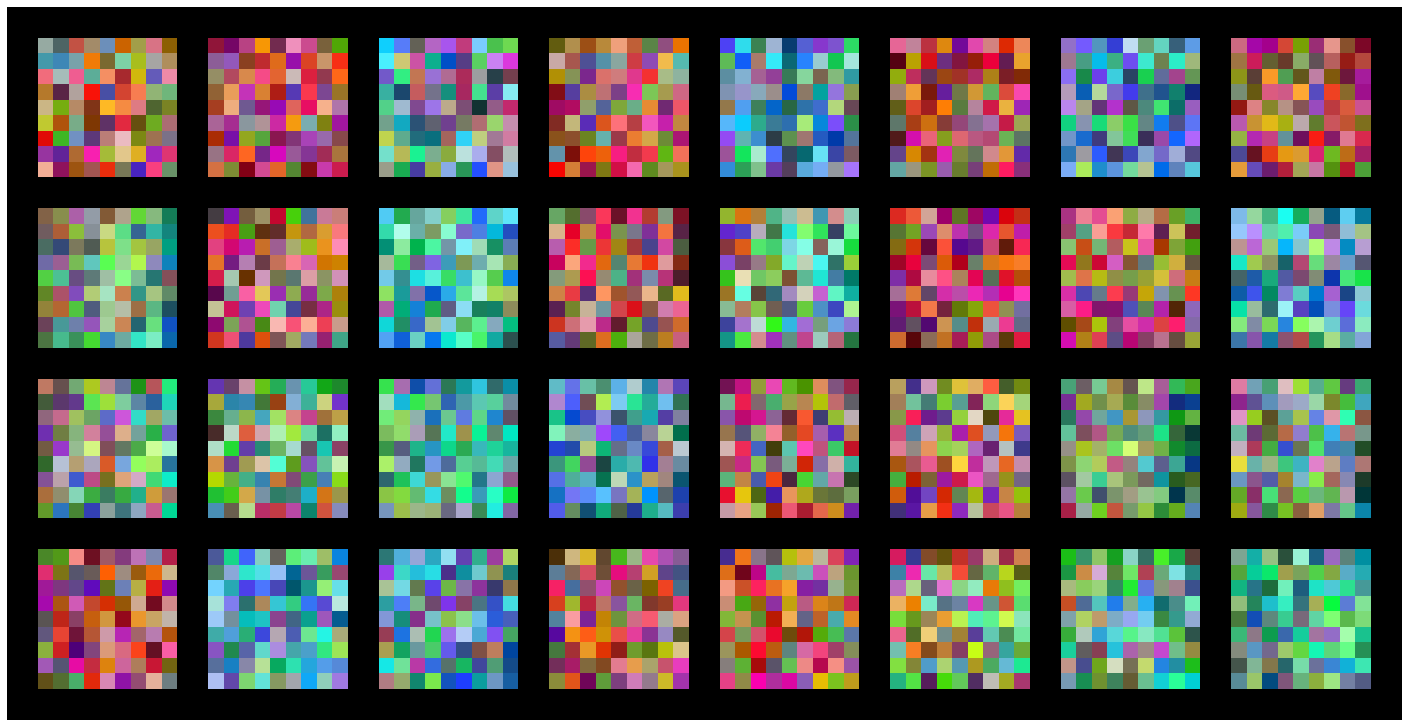

In [28]:
filter_grid = torchvision.utils.make_grid(cnn_model.conv1[0].weight, 
                                          nrow=8, normalize=True, 
                                          scale_each=True)
filter_grid_pil = torchvision.transforms.functional.to_pil_image(filter_grid)
fig = plt.figure(figsize=(25, 25))
ax = plt.axes()
ax.set_aspect('equal')
plt.imshow(filter_grid_pil)
plt.axis('off')
plt.show()

Not very easy to interpret. Maybe let's have a look at the activation maps of the CNN for some given example.

In [30]:
data = test_set[:]
images = data['image']
labels = data['label'].numpy()
predicted = cnn_model(images, return_argmax=True).detach().numpy()
correctly_predicted = (labels == predicted)
positive_samples = (predicted == 1)
negative_samples = (predicted == 0)

TP = (correctly_predicted & positive_samples)
TN = (correctly_predicted & negative_samples)
FP = (~correctly_predicted & positive_samples)
FN = (~correctly_predicted & negative_samples) 

In [31]:
conv1_activations = cnn_model.conv1(images)
conv1_activations_maxed = cnn_model.max_pool_2(conv1_activations)
conv2_activations = cnn_model.conv2(conv1_activations_maxed)
conv2_activations_maxed = cnn_model.max_pool_5(conv2_activations)
conv3_activations = cnn_model.conv3(conv2_activations_maxed)
conv3_activations_maxed = cnn_model.max_pool_5(conv3_activations)

activations = {
    1: {
        True: conv1_activations_maxed,
        False: conv1_activations
    },
    2: {
        True: conv2_activations_maxed,
        False: conv2_activations
    },
    3: {
        True: conv3_activations_maxed,
        False: conv3_activations
    }
}

In [32]:
%matplotlib inline
def visualize_activations(sample_idx, conv_layer, return_max_activation):
    
    plt.figure()
    plt.imshow(torchvision.transforms.functional.to_pil_image(images[sample_idx]*255))
    plt.axis('off')
    
    fig = plt.figure(figsize=(25, 25))
    ax = plt.axes()
    plt.title('Predicted: {}, Correct: {}'.format(predicted[sample_idx], labels[sample_idx]),
              fontsize=20)
    
    activs = activations[conv_layer][return_max_activation][sample_idx].unsqueeze(1)
    torch_images = torchvision.utils.make_grid(activs, nrow=8, normalize=(conv_layer!=3), 
                                               pad_value=0.5, scale_each=True)
    pil_images = torchvision.transforms.functional.to_pil_image(torch_images)
    
    plt.axis('off')
    plt.imshow(pil_images)
    ax.set_aspect('equal')
    
    plt.show()

In [33]:
from ipywidgets import interact, interact_manual

In [34]:
tp_sample_idx = np.random.choice(np.argwhere(TP).squeeze())
tn_sample_idx = np.random.choice(np.argwhere(TN).squeeze())
fp_sample_idx = np.random.choice(np.argwhere(FP).squeeze())
fn_sample_idx = np.random.choice(np.argwhere(FN).squeeze())

print('Correctly predicted as Non-IDC: sample with idx {}'.format(tn_sample_idx))
print('Correctly predicted as IDC: sample with idx {}'.format(tp_sample_idx))
print('Misclassified as Non-IDC: sample with idx {}'.format(fn_sample_idx))
print('Misclassified as IDC: sample with idx {}'.format(fp_sample_idx))

Correctly predicted as Non-IDC: sample with idx 863
Correctly predicted as IDC: sample with idx 1009
Misclassified as Non-IDC: sample with idx 1091
Misclassified as IDC: sample with idx 716


In [35]:
interact(visualize_activations, 
         sample_idx=range(len(labels)), 
         conv_layer=[1,2,3], 
         return_max_activation=[True, False]);

interactive(children=(Dropdown(description='sample_idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## Interpreting with `depiction`!

Let's now see what insights can we get with `depiction`. First we wrap our previously implemented CNN model into one of `depiction` interface model. In this case we are gonna use `depiction.models.torch.core.TorchModel`. 

In [37]:
from skimage.segmentation import quickshift
segmenter = lambda x: quickshift(x, kernel_size=4, max_dist=14, ratio=0.4)

In [38]:
tp_sample_idx = np.random.choice(np.argwhere(TP).squeeze())
tn_sample_idx = np.random.choice(np.argwhere(TN).squeeze())
fp_sample_idx = np.random.choice(np.argwhere(FP).squeeze())
fn_sample_idx = np.random.choice(np.argwhere(FN).squeeze())

print('Correctly predicted as Non-IDC: sample with idx {}'.format(tn_sample_idx))
print('Correctly predicted as IDC: sample with idx {}'.format(tp_sample_idx))
print('Misclassified as Non-IDC: sample with idx {}'.format(fn_sample_idx))
print('Misclassified as IDC: sample with idx {}'.format(fp_sample_idx))

Correctly predicted as Non-IDC: sample with idx 1068
Correctly predicted as IDC: sample with idx 973
Misclassified as Non-IDC: sample with idx 420
Misclassified as IDC: sample with idx 891


In [39]:
example = X_test[420] # choose the sample you want to interpret

### Excellent, now some gradient! 

In [118]:
from captum.attr import InputXGradient

In [119]:
interpreter = InputXGradient(cnn_model)

In [120]:
interpreter.has_convergence_delta()

False

In [121]:
example.shape

(50, 50, 3)

In [122]:
preprocessor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0]*3, [255]*3, inplace=True)
])

def prepare_sample(samples):
    return torch.stack([preprocessor(s) for s in samples])


In [124]:
samples = prepare_sample(np.expand_dims(example, 0))

In [125]:
samples.shape

torch.Size([1, 3, 50, 50])

In [126]:
exp = interpreter.attribute(samples, target=0)

In [127]:
exp.shape

torch.Size([1, 3, 50, 50])

In [128]:
exp = np.transpose(exp.detach().numpy()[0], (1, 2, 0))

In [129]:
exp.shape

(50, 50, 3)

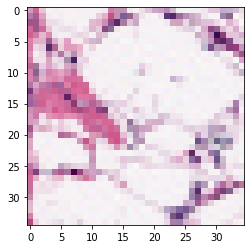

In [143]:
from matplotlib.colors import Normalize

normaliser = Normalize()

plt.imshow(normaliser(example)[15:, 15: ,:])
plt.show()

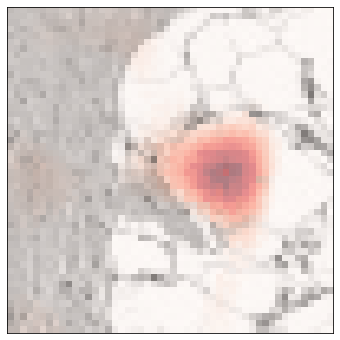

In [136]:
from captum.attr import visualization as viz

viz.visualize_image_attr(exp, original_image=normaliser(example), 
                         method="blended_heat_map", sign="negative")
plt.show()

In [137]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(cnn_model)

In [139]:
ig.has_convergence_delta()

True

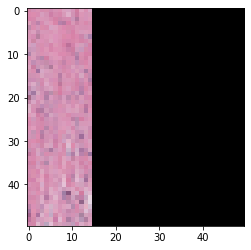

In [173]:
baseline = np.zeros_like(example)
baseline[:, :15, :] = example[:, :15, ...]

plt.imshow(baseline)
plt.show()

In [174]:
exp, conv_delta = ig.attribute(prepare_sample(np.expand_dims(example, 0)), 
                               baselines=prepare_sample(np.expand_dims(baseline, 0)),
                               target=0, 
                               return_convergence_delta=True)

In [175]:
conv_delta

tensor([-0.0112], dtype=torch.float64)

In [176]:
exp = np.transpose(exp.detach().numpy()[0], (1, 2, 0))

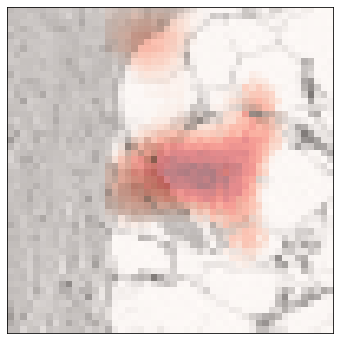

In [177]:
viz.visualize_image_attr(exp, original_image=normaliser(example), 
                         method="blended_heat_map", sign="negative")
plt.show()